In [1]:
import pandas, urllib, numpy

In [2]:
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

In [4]:
# pip install git+https://github.com/Maayanlab/maayanlab-bioinformatics.git
import maayanlab_bioinformatics, maayanlab_bioinformatics.enrichment

# read info

In [5]:
enrichr_library = 'WikiPathways_2024_Human'

In [6]:
inputfile = '/Users/adrian/hub/vigur/003.proteomics/colored_proteins_04.tsv'
df = pandas.read_csv(inputfile, sep='\t')
df.head()

,Uniprot_ID,Uniprot_gene_ID,Gene_name,ENSEMBL,Description,Color_in_plot,log2FC,Adjusted_P_value
0,P32856,STX2_HUMAN,STX2,ENSG00000111450,Syntaxin-2,blue,-0.304451,0.038247
1,H0Y6V6,H0Y6V6_HUMAN,LMBR1,ENSG00000105983,Limb region 1 protein homolog (Fragment),blue,-0.286919,0.035697
2,P52907,CAZA1_HUMAN,CAPZA1,ENSG00000116489,F-actin-capping protein subunit alpha-1,blue,-0.545673,0.035697
3,Q04446,GLGB_HUMAN,GBE1,ENSG00000114480,"1,4-alpha-glucan-branching enzyme",green,-0.137961,0.014242
4,P28482,MK01_HUMAN,MAPK1,ENSG00000100030,Mitogen-activated protein kinase 1,blue,-0.413359,0.010867


In [7]:
sub = df[(df['Color_in_plot'] == 'blue') | (df['Color_in_plot'] == 'red')] # get blue or red. Another notebook for 4 hours.
v = list(sub['Gene_name'].dropna())
genes = list(set(v))
gene_list = [x.strip() for x in genes]
print(len(gene_list))

211


In [8]:
def get_library(lib_name):
    '''
    Returns a dictionary mapping each term from the input library to 
    its associated geneset. 
    '''
    raw_lib_data = []

    with urllib.request.urlopen('https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName=' + lib_name) as f:
        for line in f.readlines():
            raw_lib_data.append(line.decode("utf-8").split("\t\t"))

    name = []
    gene_list = []
    lib_data = {}

    for i in range(len(raw_lib_data)):
        name += [raw_lib_data[i][0]]
        raw_genes = raw_lib_data[i][1].replace('\t', ' ')
        gene_list += [raw_genes[:-1]]
    
    lib_data = {a[0]:a[1].split(' ') for a in zip(name, gene_list)}
    return lib_data

lib_data = get_library(enrichr_library)

enrich_results = maayanlab_bioinformatics.enrichment.enrich_crisp(genes, lib_data, 21000, True)

res_df = pandas.DataFrame(
    [ [
        term, 
        res.pvalue, 
        res.odds_ratio,
        res.n_overlap,

    ] for (term, res) in enrich_results ], 
    columns=['term', 'pvalue', 'odds_ratio', 'n_overlap']
)
res_df

,term,pvalue,odds_ratio,n_overlap
0,TCA Cycle And Deficiency Of Pyruvate Dehydroge...,0.157801,6.182440,1
1,Hypothesized Pathways In Pathogenesis Of Cardi...,0.231040,3.955048,1
2,TGF Beta In Thyroid Cells For Epithelial Mesen...,0.166270,5.818487,1
3,mRNA Protein And Metabolite Inducation Pathway...,0.077623,14.137415,1
4,Chromosomal And Microsatellite Instability In ...,0.170436,2.753456,2
...,...,...,...,...
380,MAPK Cascade WP422,0.290800,2.995094,1
381,IL2 Signaling WP49,0.318924,2.670785,1
382,Cell Cycle WP179,0.706370,0.820198,1
383,Apoptosis WP254,0.576879,1.173753,1


In [9]:
# checked done, all good
container = []
for pathway in res_df['term']:
    
    overlap_genes = []
    for query in lib_data[pathway]:
        if query in genes:
            overlap_genes.append(query)
    overlap_genes_string = ', '.join(overlap_genes)
    container.append(overlap_genes_string)
    
res_df.loc[:, 'overlap_genes'] = container
res_df

,term,pvalue,odds_ratio,n_overlap,overlap_genes
0,TCA Cycle And Deficiency Of Pyruvate Dehydroge...,0.157801,6.182440,1,IDH1
1,Hypothesized Pathways In Pathogenesis Of Cardi...,0.231040,3.955048,1,MAPK1
2,TGF Beta In Thyroid Cells For Epithelial Mesen...,0.166270,5.818487,1,MAPK1
3,mRNA Protein And Metabolite Inducation Pathway...,0.077623,14.137415,1,SLC7A5
4,Chromosomal And Microsatellite Instability In ...,0.170436,2.753456,2,"CASP3, MAPK1"
...,...,...,...,...,...
380,MAPK Cascade WP422,0.290800,2.995094,1,MAPK1
381,IL2 Signaling WP49,0.318924,2.670785,1,MAPK1
382,Cell Cycle WP179,0.706370,0.820198,1,CCNB1
383,Apoptosis WP254,0.576879,1.173753,1,CASP3


# multiple test correction

In [10]:
results = statsmodels.stats.multitest.multipletests(res_df['pvalue'], alpha=0.05, method='fdr_bh')
res_df['adjusted'] = results[1]

# plot

(314, 6)
(71, 6)


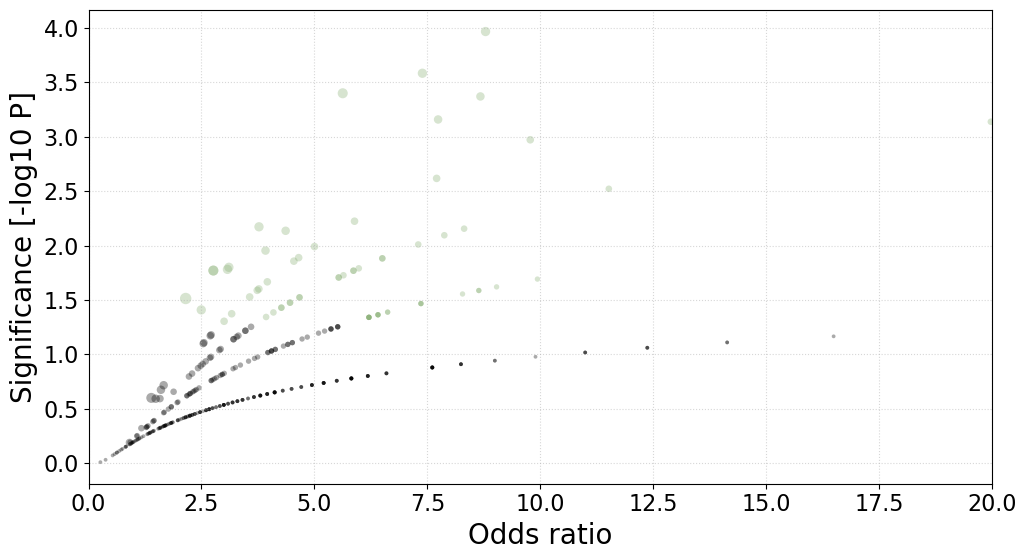

In [11]:
a = res_df[(res_df['pvalue'] > 0.05) | (res_df['odds_ratio'] < 2)]
print(a.shape)
x = a['odds_ratio']
y = -numpy.log10(a['pvalue'])
names = a['term']
s = a['n_overlap']
matplotlib.pyplot.scatter(x, y, s*7.5, alpha=1/3, edgecolors='none', color='black')

b = res_df[(res_df['pvalue'] < 0.05) & (res_df['odds_ratio'] > 2)]
print(b.shape)
x = b['odds_ratio']
y = -numpy.log10(b['pvalue'])
names = b['term']
s = b['n_overlap']
matplotlib.pyplot.scatter(x, y, s*7.5, alpha=1/3, edgecolors='none', color='xkcd:sage')

matplotlib.pyplot.xlim(0, 20)

matplotlib.pyplot.xlabel('Odds ratio')
matplotlib.pyplot.ylabel('Significance [-log10 P]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

(376, 6)
(9, 6)
1	42.8593580688855	Hemesynthesis Defects And Porphyrias WP5169	0.014619537405021685
2	42.8593580688855	Heme Biosynthesis WP561	0.014619537405021685
3	20.027871542452562	ERK Pathway In Huntington 39 S Disease WP3853	0.03513107135189325
4	9.870077835820487	IL11 Signaling WP2332	0.04572987884346707
5	8.978501338558285	Burn Wound Healing WP5055	0.014619537405021685
6	8.814938288551147	Proteasome Degradation WP183	0.02743980568608732
7	7.87407850095603	Urotensin II Mediated Signaling WP5158	0.03513107135189325
8	7.561882968514979	Androgen Receptor Signaling WP138	0.025194608005722298
9	5.839845319259871	TGF Beta Signaling Pathway WP366	0.02743980568608732


/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_61207/1776320957.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.loc[:, 'importance'] = importance


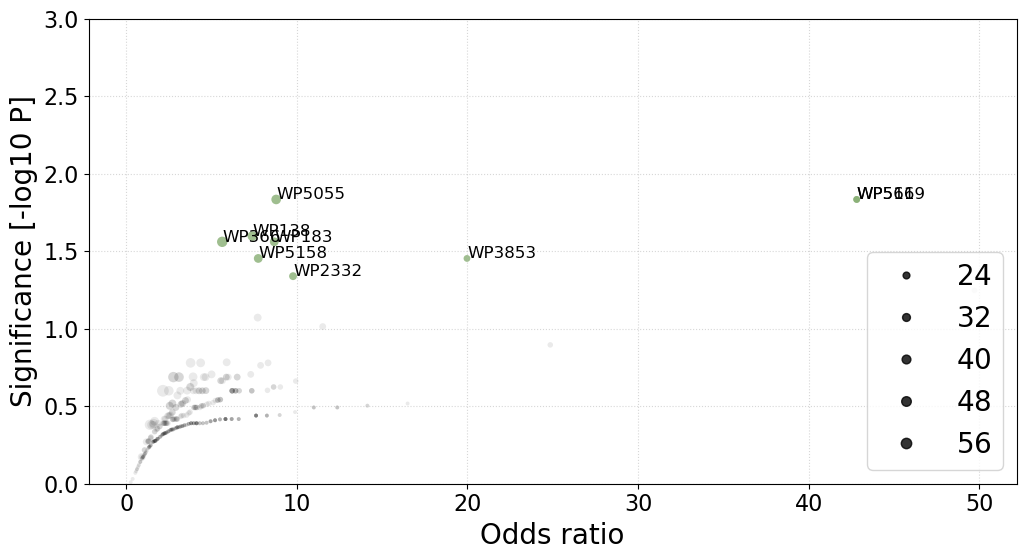

In [16]:
a = res_df[(res_df['adjusted'] > 0.05) | (res_df['odds_ratio'] < 2)]
print(a.shape)
x = a['odds_ratio']
y = -numpy.log10(a['adjusted'])
s = a['n_overlap']
matplotlib.pyplot.scatter(x, y, s*8, alpha=1/12, edgecolors='none', color='black')

b = res_df[(res_df['adjusted'] < 0.05) & (res_df['odds_ratio'] > 2)]
print(b.shape)
x = b['odds_ratio']
y = -numpy.log10(b['adjusted'])
s = b['n_overlap']
sc = matplotlib.pyplot.scatter(x, y, s*8, alpha=0.8, edgecolors='none', color='xkcd:sage')

x = list(b['odds_ratio'])
y = list(-numpy.log10(b['adjusted']))
prez = list(b['term'].values)
z = [element.split()[-1] for element in prez]
w = list(b['overlap_genes'].values)
importance = [numpy.sqrt(x[i]**2 + y[i]**2) for i in range(len(x))]
b.loc[:, 'importance'] = importance
c = b.sort_values('importance', ascending=False)

threshold = 5
com = c[c['importance'] > threshold]
count = 0
for index, row in com.iterrows():
    x = row['odds_ratio']
    y = -numpy.log10(row['adjusted'])
    label = row['term'].split()[-1]
    matplotlib.pyplot.text(x, y, label, fontsize=12)
    count = count + 1
    print('{}\t{}\t{}\t{}'.format(count, row['importance'], row['term'], row['adjusted']))

matplotlib.pyplot.legend(*sc.legend_elements("sizes", num=4))
matplotlib.pyplot.ylim(0, 3)
matplotlib.pyplot.xlabel('Odds ratio')
matplotlib.pyplot.ylabel('Significance [-log10 P]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('functions.04.svg')

In [13]:
c.head()

,term,pvalue,odds_ratio,n_overlap,overlap_genes,adjusted,importance
169,Hemesynthesis Defects And Porphyrias WP5169,0.000114,42.820055,3,"ALAD, HMBS, CPOX",0.014620,42.859358
343,Heme Biosynthesis WP561,0.000114,42.820055,3,"ALAD, HMBS, CPOX",0.014620,42.859358
144,ERK Pathway In Huntington 39 S Disease WP3853,0.000730,19.975000,3,"EGFR, CASP3, MAPK1",0.035131,20.027872
347,IL11 Signaling WP2332,0.001069,9.778720,4,"FES, IL6ST, ICAM1, MAPK1",0.045730,9.870078
323,Burn Wound Healing WP5055,0.000108,8.788971,6,"AMBP, PECAM1, CASP3, BRD4, ICAM1, CXCR4",0.014620,8.978501


In [14]:
print(c.shape)
c.drop('pvalue', axis='columns', inplace=True)
d = c.iloc[:, [0, 5, 4, 1, 2, 3]]
d.rename(columns={"term": "Term", 
                  "importance": "Priority", 
                  'adjusted':'Adjusted P', 
                  'odds_ratio':'Odds ratio',
                 'n_overlap':'N overlap',
                 'overlap_genes':'Overlap genes'}, inplace=True)
d.set_index('Term', inplace=True)
d.head()
d.to_csv('functional_analysis.04.tsv', sep='\t')

(9, 7)


In [15]:
d.to_csv('functional_analysis.04.tsv', sep='\t')